# Project 3.2

<br>

Yuan Wang | Yiwei Li

ywang340 | yli253

2021/12/10

In [40]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
from arff2pandas import a2p

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [74]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [75]:
#Load the arff files into Pandas data frames / Change Path as needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with open('ECG5000_TRAIN.arff') as f:
    train = a2p.load(f)

with open('ECG5000_TEST.arff') as f:
    test = a2p.load(f)

#We'll combine the training and test data into a single data frame. This will give us more data to train our Autoencoder. We'll also shuffle it:"""

df = train.append(test)
df = df.sample(frac=1.0)
df.shape

df.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,...,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,...,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,1
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,...,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,1
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,...,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,1
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,...,0.545222,0.649363,0.986846,1.234495,1.280039,1.215985,1.617971,2.196543,0.023843,1
205,-1.197203,-3.270123,-3.778723,-3.977574,-3.405060,-2.392634,-1.726322,-1.572748,-0.920075,-0.388731,...,0.828168,0.914338,1.063077,1.393479,1.469756,1.392281,1.144732,1.668263,1.734676,1


In [76]:
"""We have 5,000 examples. Each row represents a single heartbeat record. Let's name the possible classes:"""

CLASS_NORMAL = 1

class_names = ['Normal','R on T','PVC','SP','UB']

"""Next, we'll rename the last column to `target`, so its easier to reference it:"""

new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

df.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,...,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,target
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,...,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,1
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,...,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,1
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,...,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,1
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,...,0.545222,0.649363,0.986846,1.234495,1.280039,1.215985,1.617971,2.196543,0.023843,1
205,-1.197203,-3.270123,-3.778723,-3.977574,-3.405060,-2.392634,-1.726322,-1.572748,-0.920075,-0.388731,...,0.828168,0.914338,1.063077,1.393479,1.469756,1.392281,1.144732,1.668263,1.734676,1


In [77]:
"""Let's check how many examples for each heartbeat class do we have:"""

df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


'The normal class, has by far, the most examples. '

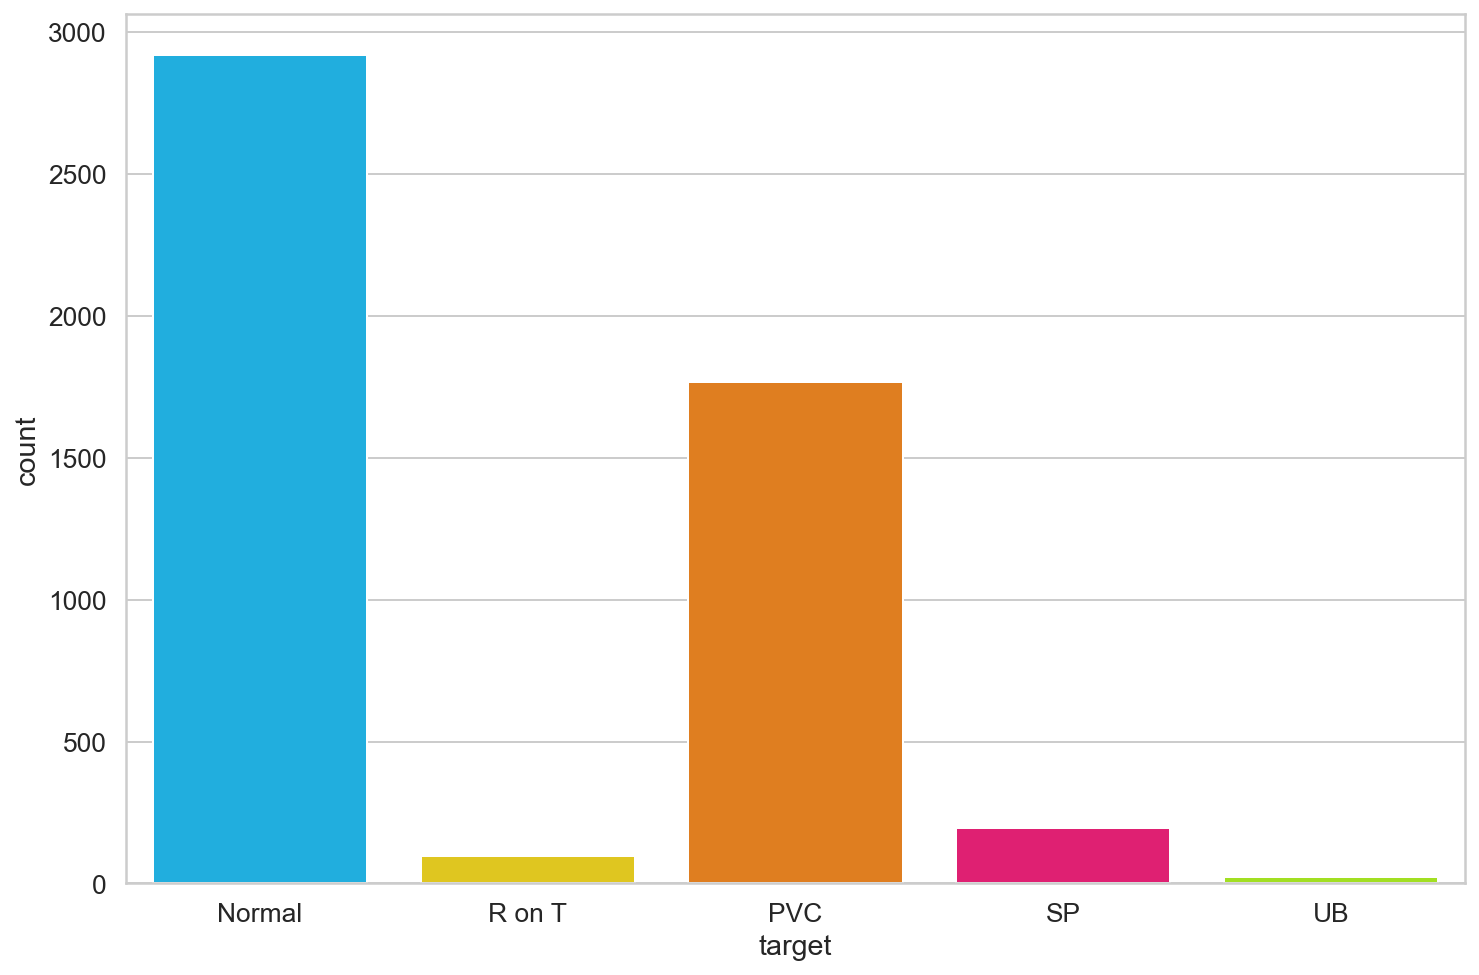

In [78]:
"""Let's plot the results:"""

ax = sns.countplot(df.target)
ax.set_xticklabels(class_names);

"""The normal class, has by far, the most examples. """

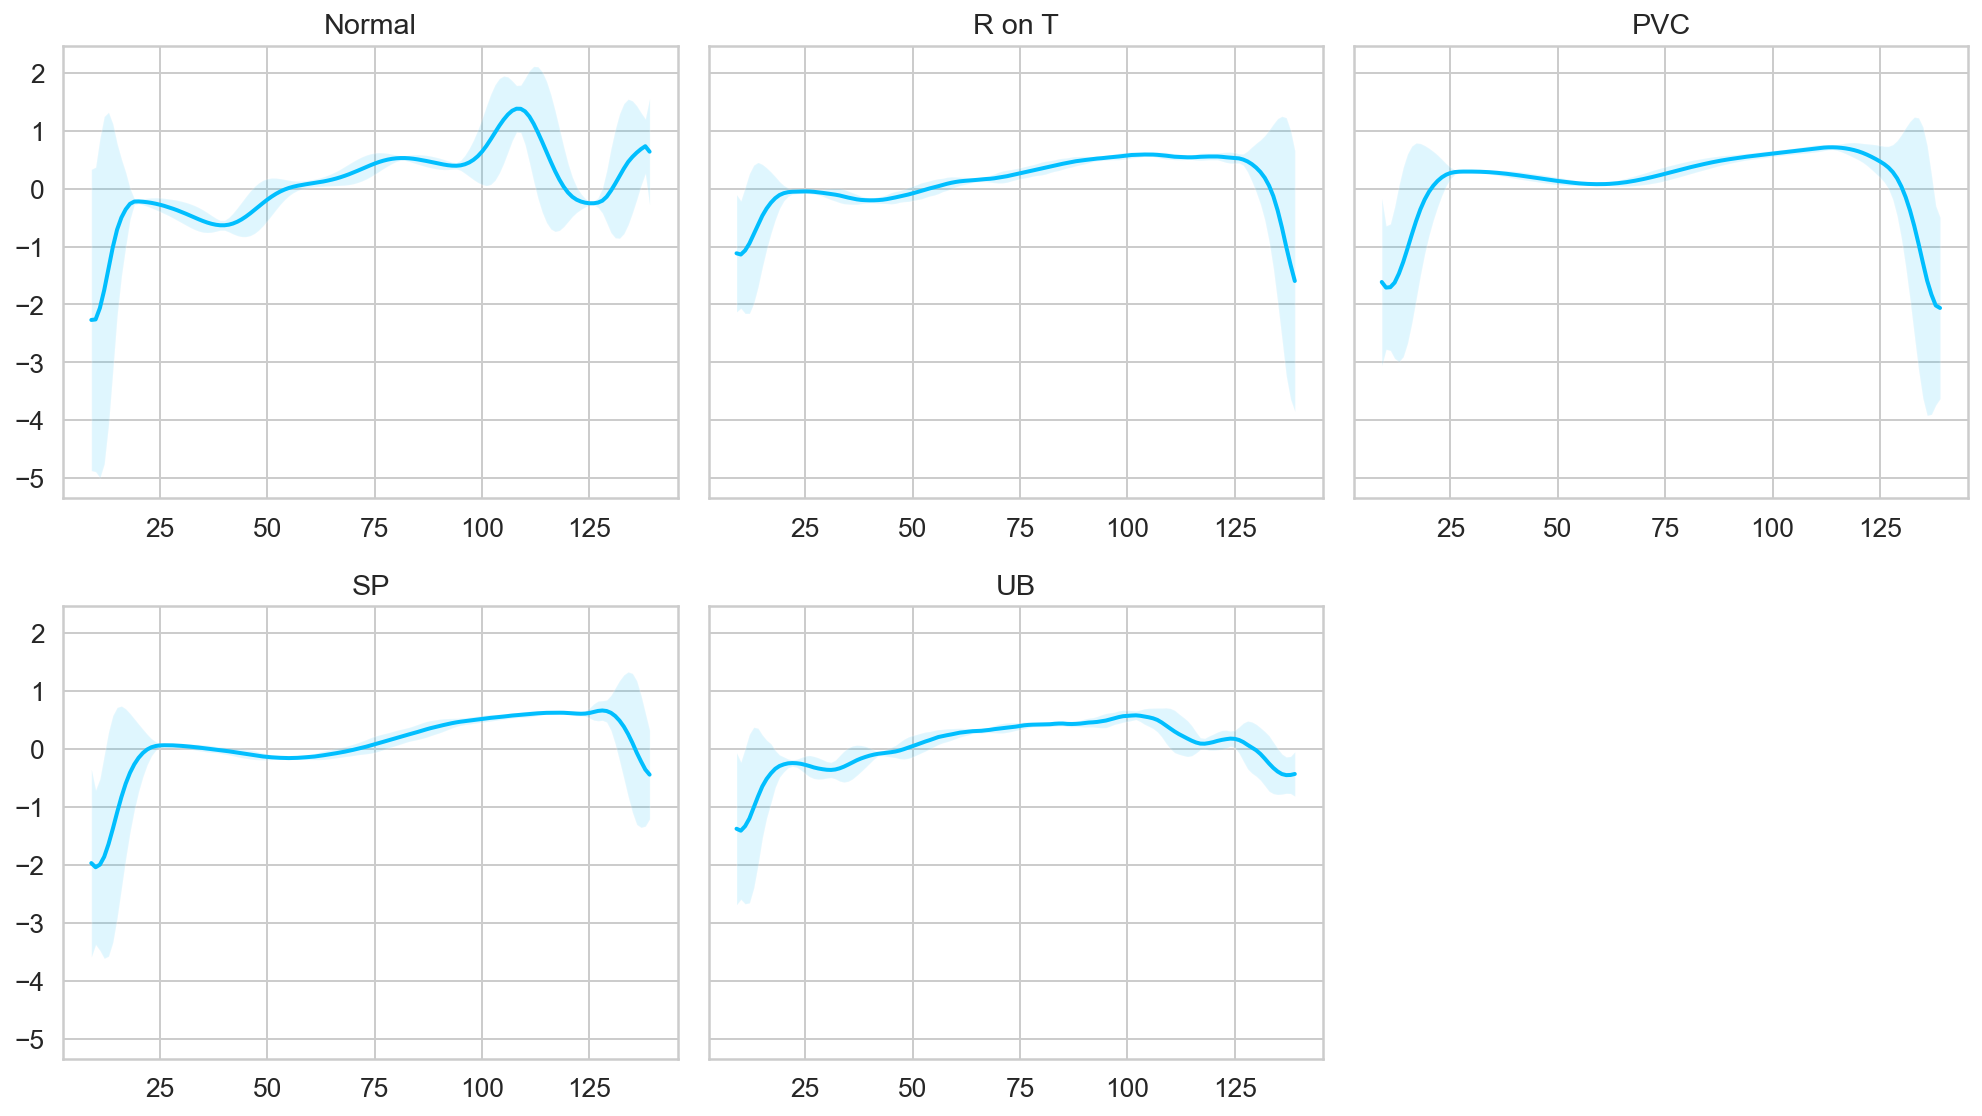

In [79]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
    time_series_df = pd.DataFrame(data)

    smooth_path = time_series_df.rolling(n_steps).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps).std()

    under_line = (smooth_path - path_deviation)[0]
    over_line = (smooth_path + path_deviation)[0]

    ax.plot(smooth_path, linewidth=2)
    ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
    )
    ax.set_title(class_name)

classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = df[df.target == cls] \
        .drop(labels='target', axis=1) \
        .mean(axis=0) \
        .to_numpy()
    plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();
plt.show()

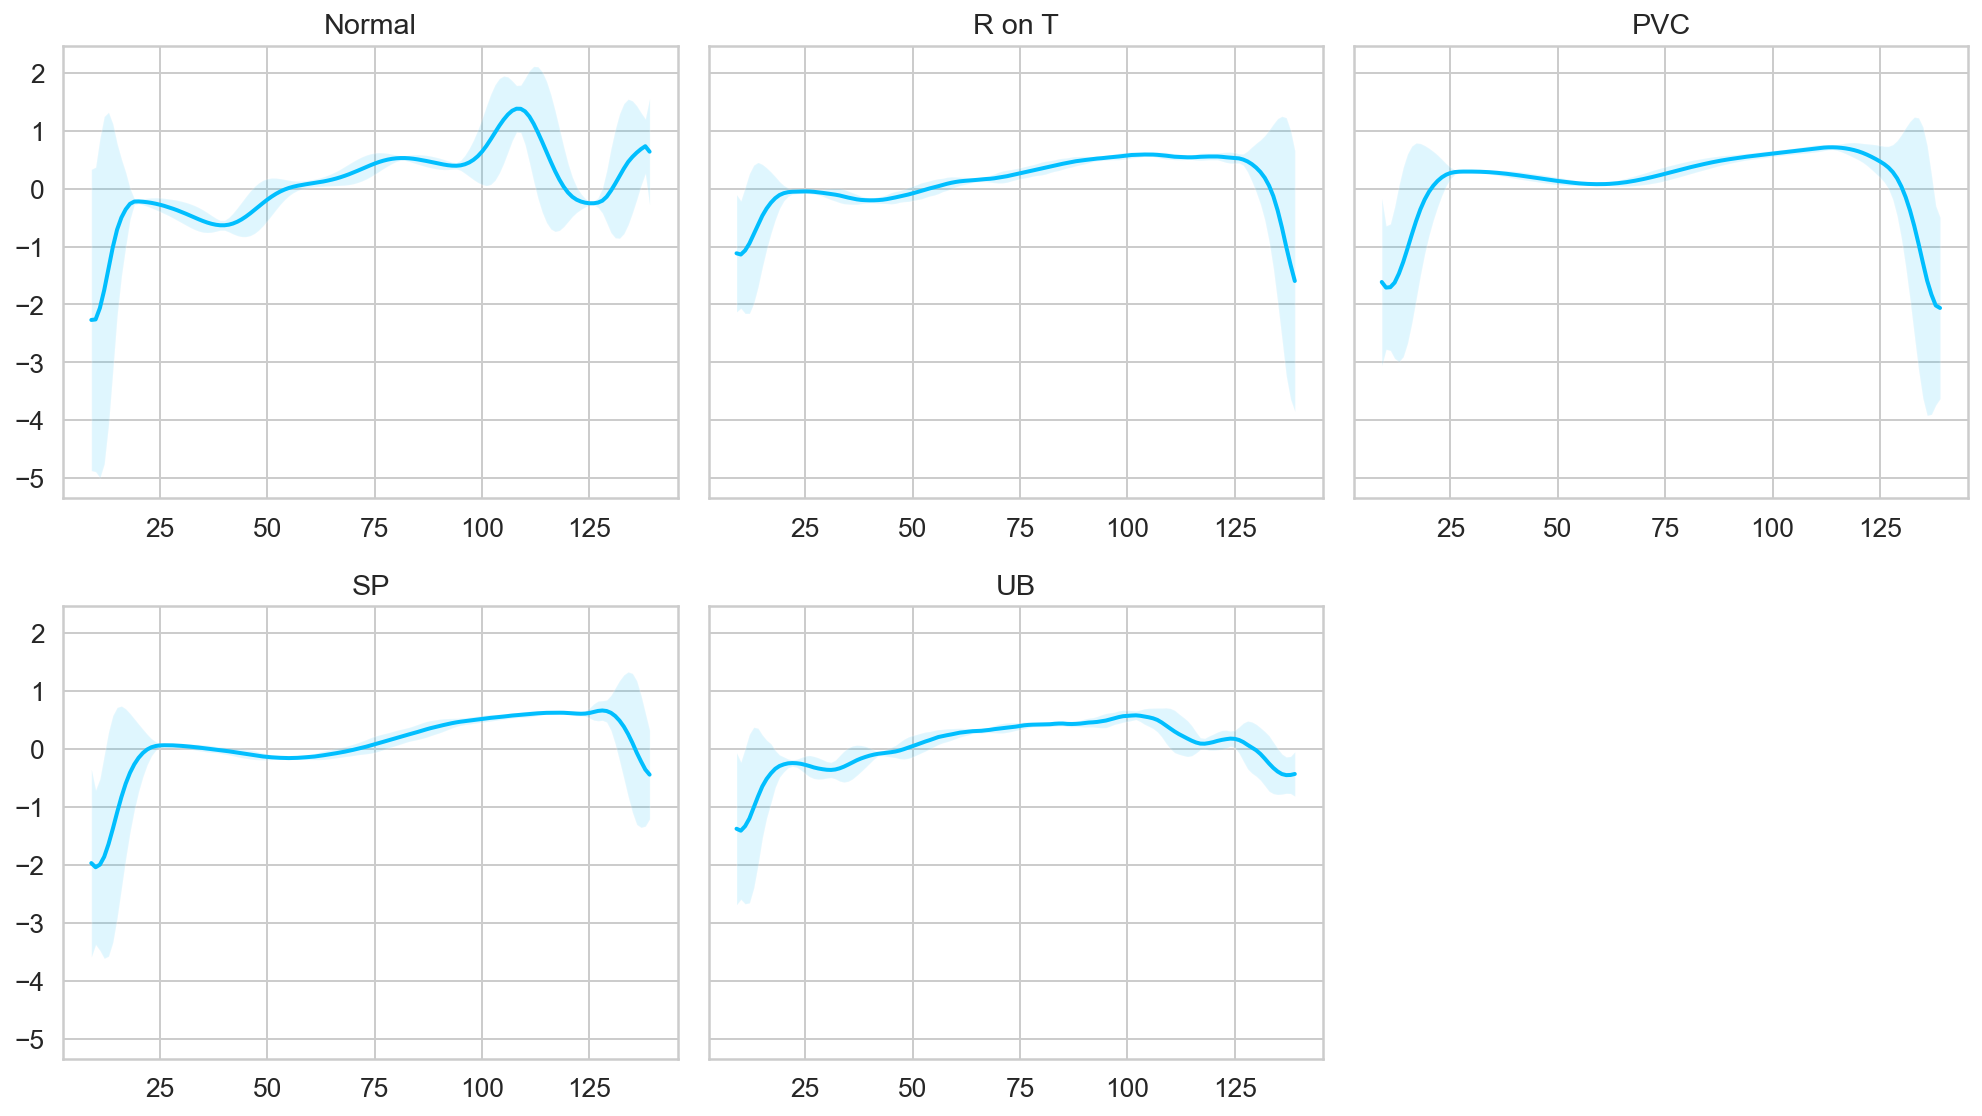

In [80]:
"""Let's have a look at an averaged (smoothed out with one standard deviation on top and bottom of it) Time Series for each class:
"""

def plot_time_series_class(data, class_name, ax, n_steps=10):
    time_series_df = pd.DataFrame(data)

    smooth_path = time_series_df.rolling(n_steps).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps).std()

    under_line = (smooth_path - path_deviation)[0]
    over_line = (smooth_path + path_deviation)[0]

    ax.plot(smooth_path, linewidth=2)
    ax.fill_between(
        path_deviation.index,
        under_line,
        over_line,
        alpha=.125
    )
    ax.set_title(class_name)

classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
    plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();
plt.show()

In [81]:
## LSTM Autoencoder

### Data Preprocessing

#Let's get all normal heartbeats and drop the target (class) column:

normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
print(normal_df.shape)

#Merge all other classes and mark them as anomalies:"""

anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
print(anomaly_df.shape)

(2919, 140)
(2081, 140)


In [82]:
#Split the normal examples into train, validation and test sets:"""

train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

In [83]:
#Convert our examples into tensors, so we can use them to train our Autoencoder. 

def create_dataset(df):

    sequences = df.astype(np.float32).to_numpy().tolist()

    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

    n_seq, seq_len, n_features = torch.stack(dataset).shape

    return dataset, seq_len, n_features

In [84]:
#Each Time Series will be converted to a 2D Tensor in the shape *sequence length* x *number of features* (140x1 in our case).

#Create Train, Val and Test datasets:

train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [85]:
# LSTM Autoencoder
#The general Autoencoder architecture consists of two components. An *Encoder* that compresses the input and a *Decoder* that tries to reconstruct it.

class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        #self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
        self.embedding_dim, self.hidden_dim = embedding_dim, embedding_dim

        self.rnn1 = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )

    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))

        #x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn1(x)
        #x, (hidden_n, _) = self.rnn2(x)

        return hidden_n.reshape((self.n_features, self.embedding_dim))



In [86]:
"""The *Encoder* uses LSTM layers to compress the Time Series data input.
Next, we'll decode the compressed representation using a *Decoder*:
"""

class Decoder(nn.Module):

    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        # self.hidden_dim, self.n_features = 2 * input_dim, n_features
        self.hidden_dim, self.n_features = input_dim, n_features

        self.rnn1 = nn.LSTM(
            input_size=input_dim,
            hidden_size=input_dim, 
            num_layers=1, 
            batch_first=True
        )

        # self.rnn2 = nn.LSTM(
        #   input_size=input_dim,
        #   hidden_size=self.hidden_dim,
        #   num_layers=1,
        #   batch_first=True
        # )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))

        x, (hidden_n, cell_n) = self.rnn1(x)
        #x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))

        return self.output_layer(x)

In [87]:
#Our Decoder contains LSTM layer and an output layer that gives the final reconstruction.

#Time to wrap everything into an easy to use module:


class RecurrentAutoencoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [88]:
"""Our Autoencoder passes the input through the Encoder and Decoder. Let's create an instance of it:"""

#model = RecurrentAutoencoder(seq_len, n_features, 128)
#model = RecurrentAutoencoder(seq_len, n_features, 8)
model = RecurrentAutoencoder(seq_len, n_features, 8)
model = model.to(device)

In [94]:
"""## Training

Let's write a helper function for our training process:
"""

def train_model(model, train_dataset, val_dataset, n_epochs):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0

    for epoch in range(1, n_epochs + 1):
        model = model.train()

        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:

                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [95]:
"""At each epoch, the training process feeds our model with all training examples and evaluates the performance on the validation set. Note that we're using a batch size of 1 (our model sees only 1 sequence at a time). We also record the training and validation set losses during the process.

Note that we're minimizing the [L1Loss](https://pytorch.org/docs/stable/nn.html#l1loss), which measures the MAE (mean absolute error). Why? The reconstructions seem to be better than with MSE (mean squared error).

We'll get the version of the model with the smallest validation error. Let's do some training:
"""

model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  n_epochs=50
#  n_epochs=25  
)

Epoch 1: train loss 68.03575748841833 val loss 66.2256141115781
Epoch 2: train loss 60.639056252260836 val loss 53.98802349103595
Epoch 3: train loss 52.87770017295632 val loss 51.80099406584131
Epoch 4: train loss 51.646619918220516 val loss 50.03274792615871
Epoch 5: train loss 50.55620734473478 val loss 49.20357699605792
Epoch 6: train loss 49.906669289198 val loss 49.03682199679951
Epoch 7: train loss 49.75261443529048 val loss 48.51820764769466
Epoch 8: train loss 49.20553927361989 val loss 48.1451259521901
Epoch 9: train loss 48.7822601475191 val loss 47.716060859758294
Epoch 10: train loss 48.63128126883209 val loss 47.292182193274385
Epoch 11: train loss 48.14421349924834 val loss 47.14931061650299
Epoch 12: train loss 47.93431656517266 val loss 46.971773310326064
Epoch 13: train loss 47.756918598499475 val loss 46.81861760266405
Epoch 14: train loss 47.56575885159217 val loss 46.78893455140827
Epoch 15: train loss 47.44611619490378 val loss 46.624494526573415
Epoch 16: train l

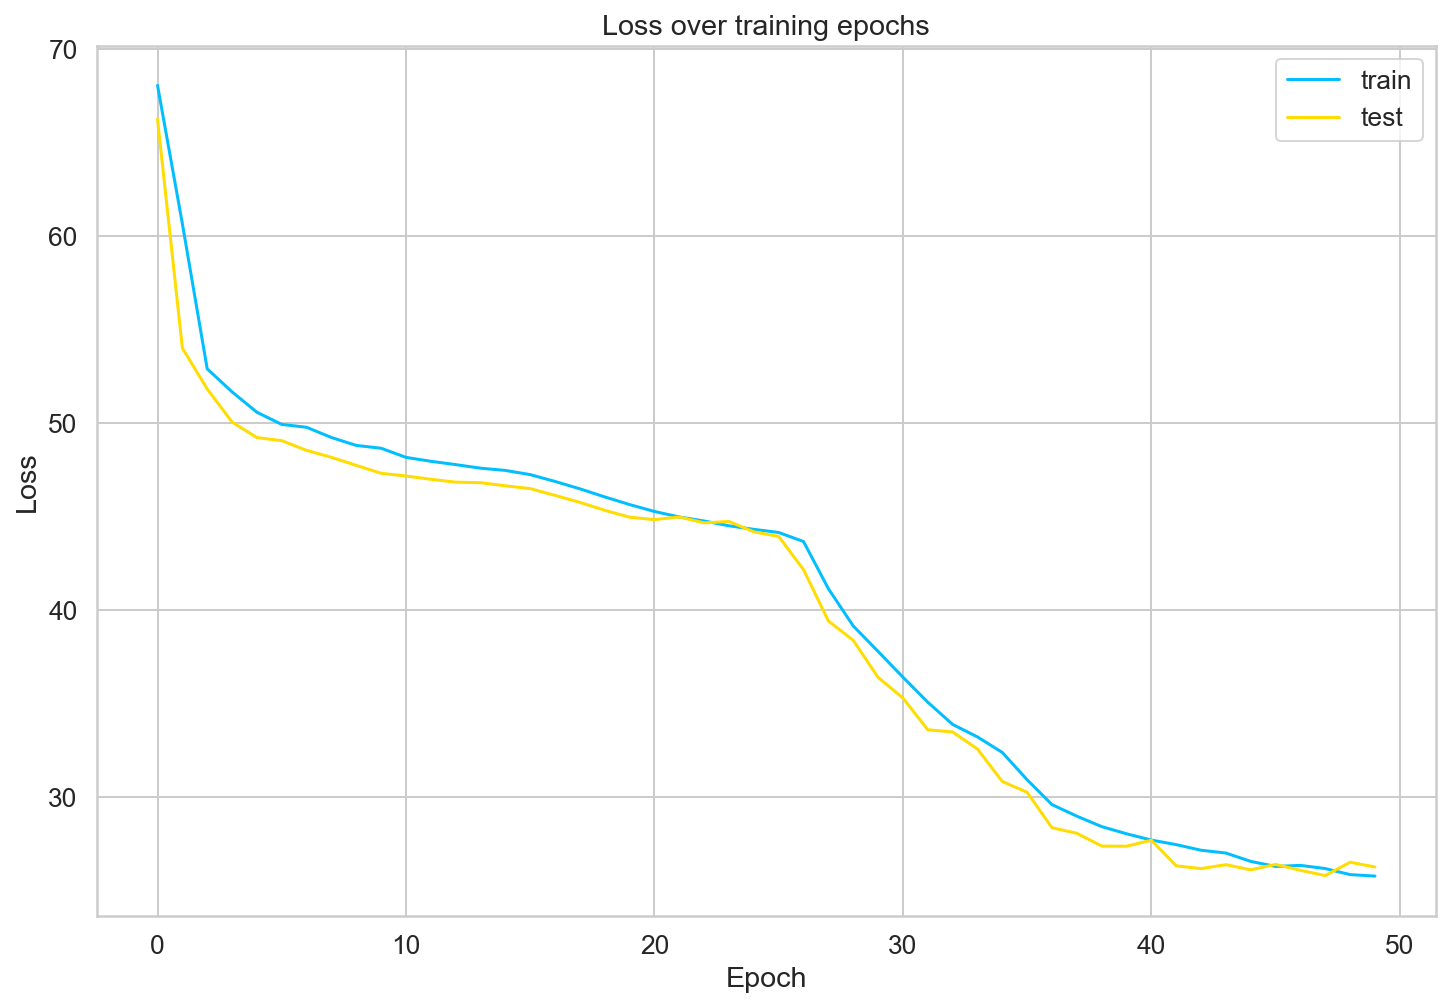

In [96]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

## Saving the model

#Let's store the model for later use:


#MODEL_PATH = 'model.pth'

#torch.save(model, MODEL_PATH)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


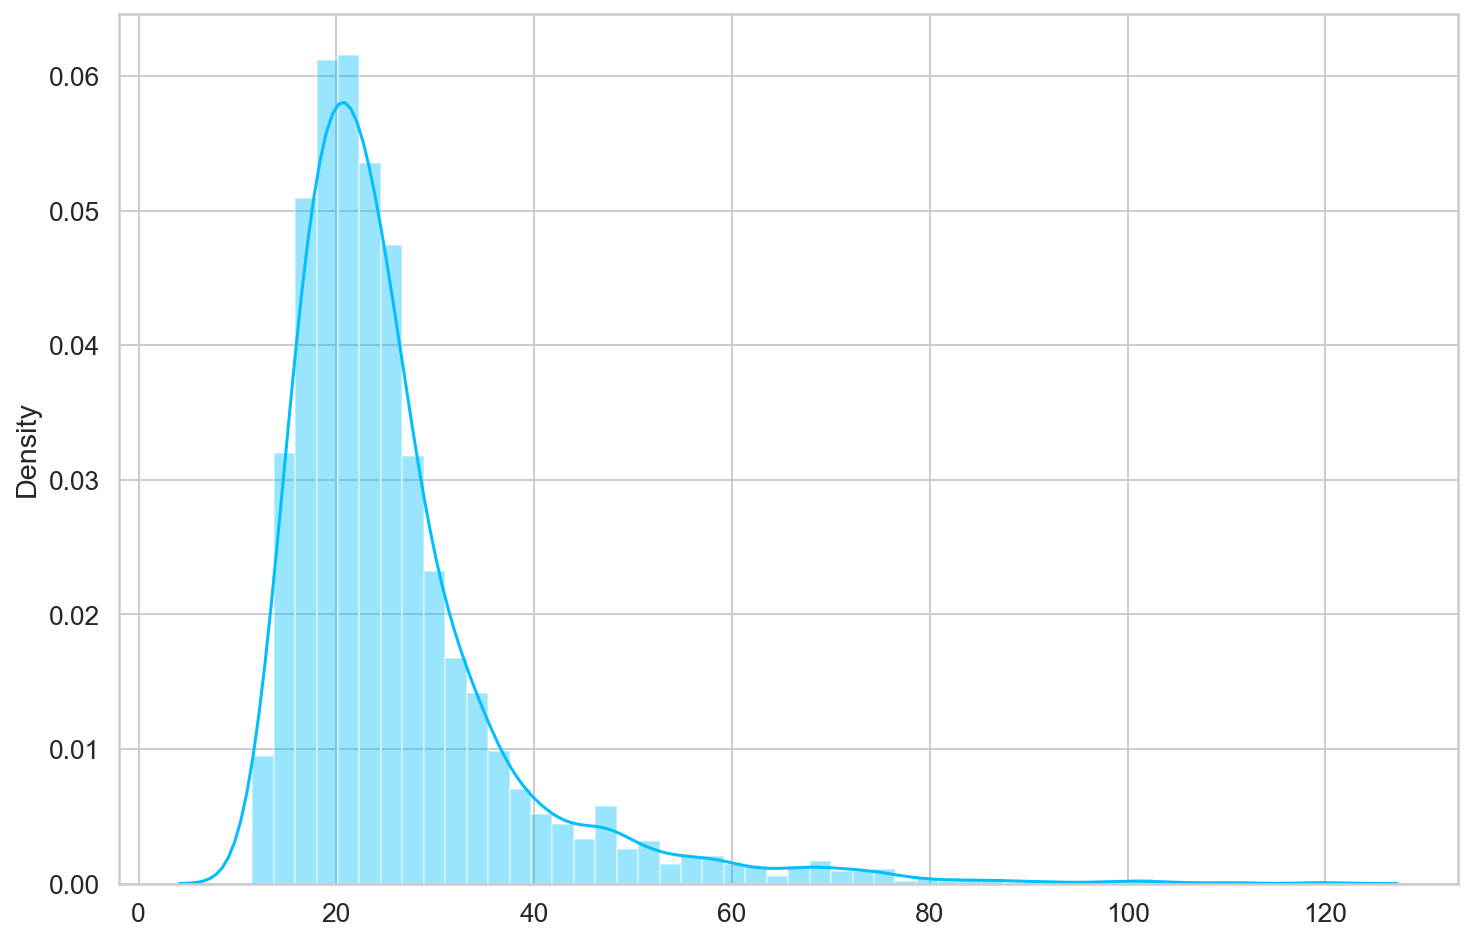

In [98]:
"""## Choosing a threshold

With our model at hand, we can have a look at the reconstruction error on the training set. Let's start by writing a helper function to get predictions from our model:
"""

def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses



"""Our function goes through each example in the dataset and records the predictions and losses. Let's get the losses and have a look at them:"""

_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

THRESHOLD = 75

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


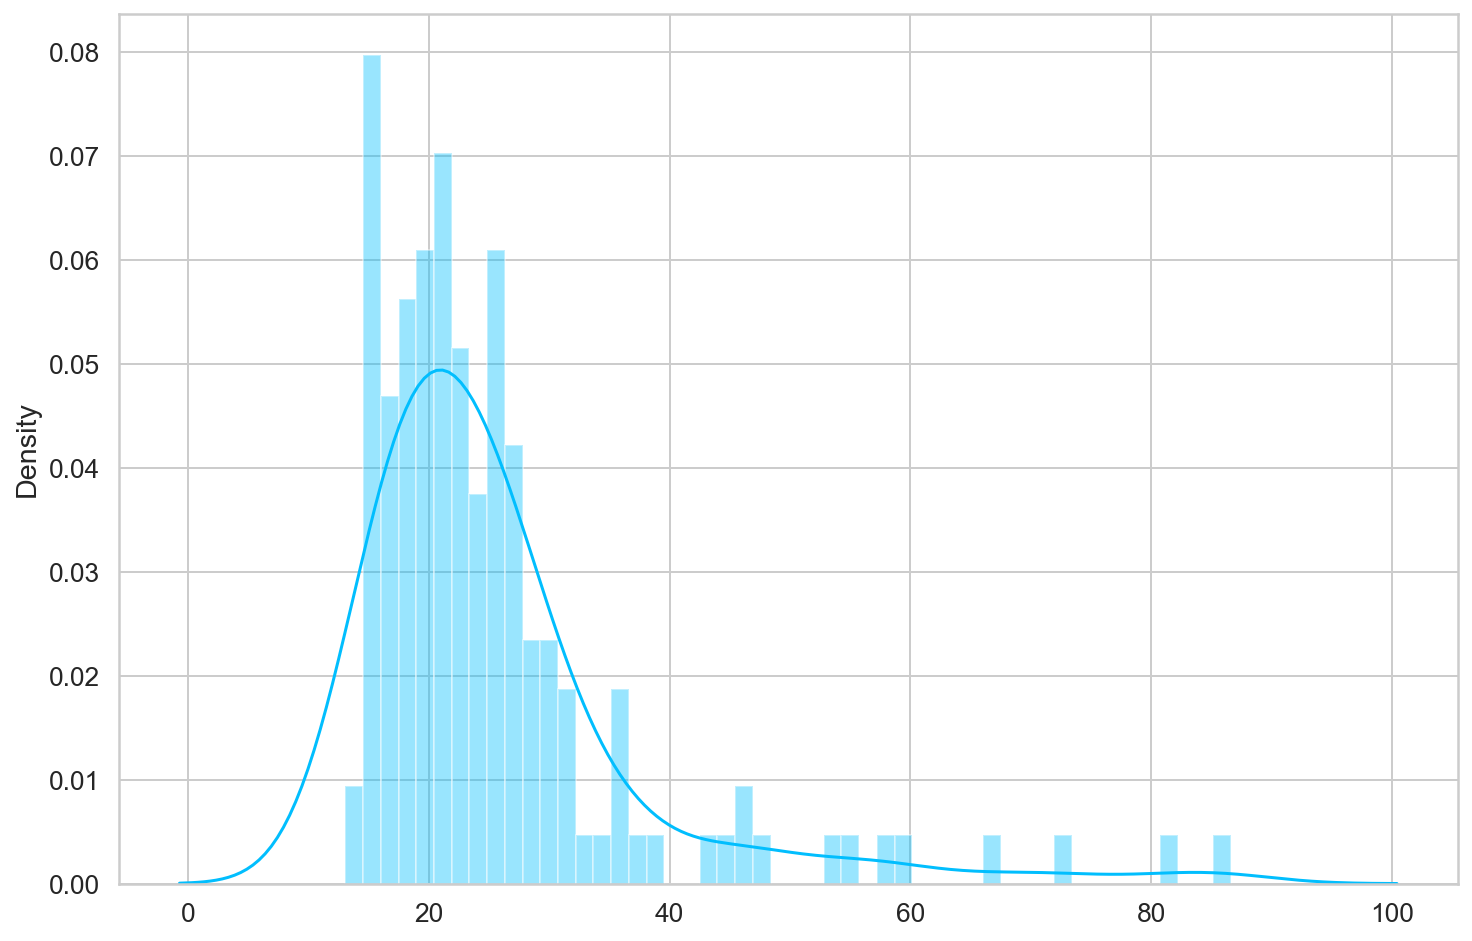

In [99]:
"""## Evaluation

Using the threshold, we can turn the problem into a simple binary classification task:

- If the reconstruction loss for an example is below the threshold, we'll classify it as a *normal* heartbeat
- Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

### Normal hearbeats

Let's check how well our model does on normal heartbeats. We'll use the normal heartbeats from the test set (our model haven't seen those):
"""

predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

Correct normal predictions: 143/145
Correct anomaly predictions: 51/145


/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


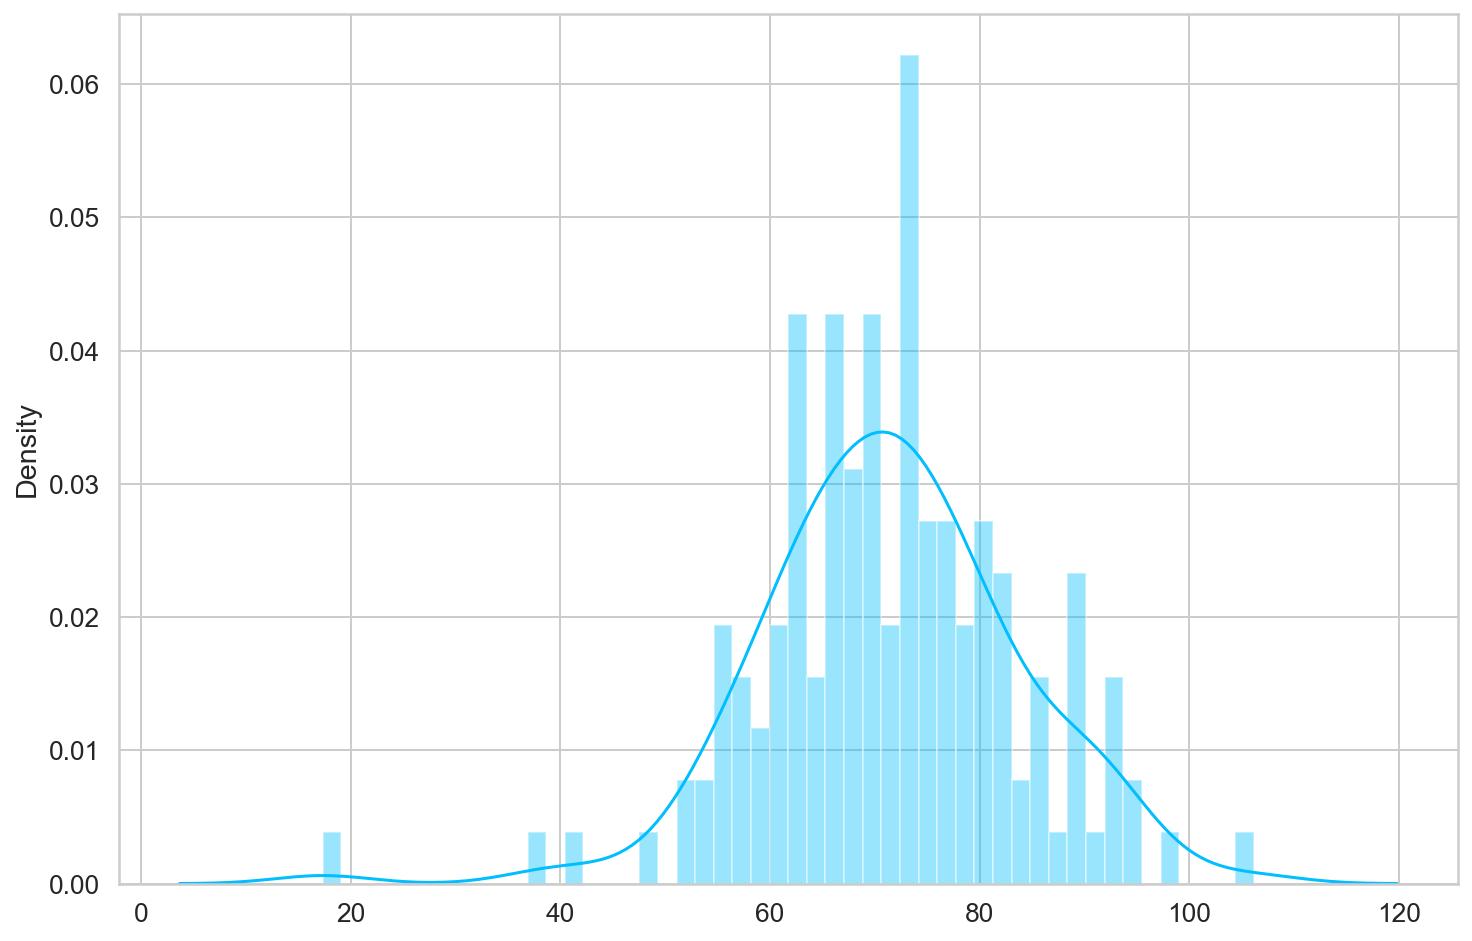

In [100]:
"""We'll count the correct predictions:"""

correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

"""### Anomalies

We'll do the same with the anomaly examples, but their number is much higher. We'll get a subset that has the same size as the normal heartbeats:
"""

anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
#anomaly_dataset = test_anomaly_dataset
"""Now we can take the predictions of our model for the subset of anomalies:"""

predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

"""Finally, we can count the number of examples above the threshold (considered as anomalies):"""

correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

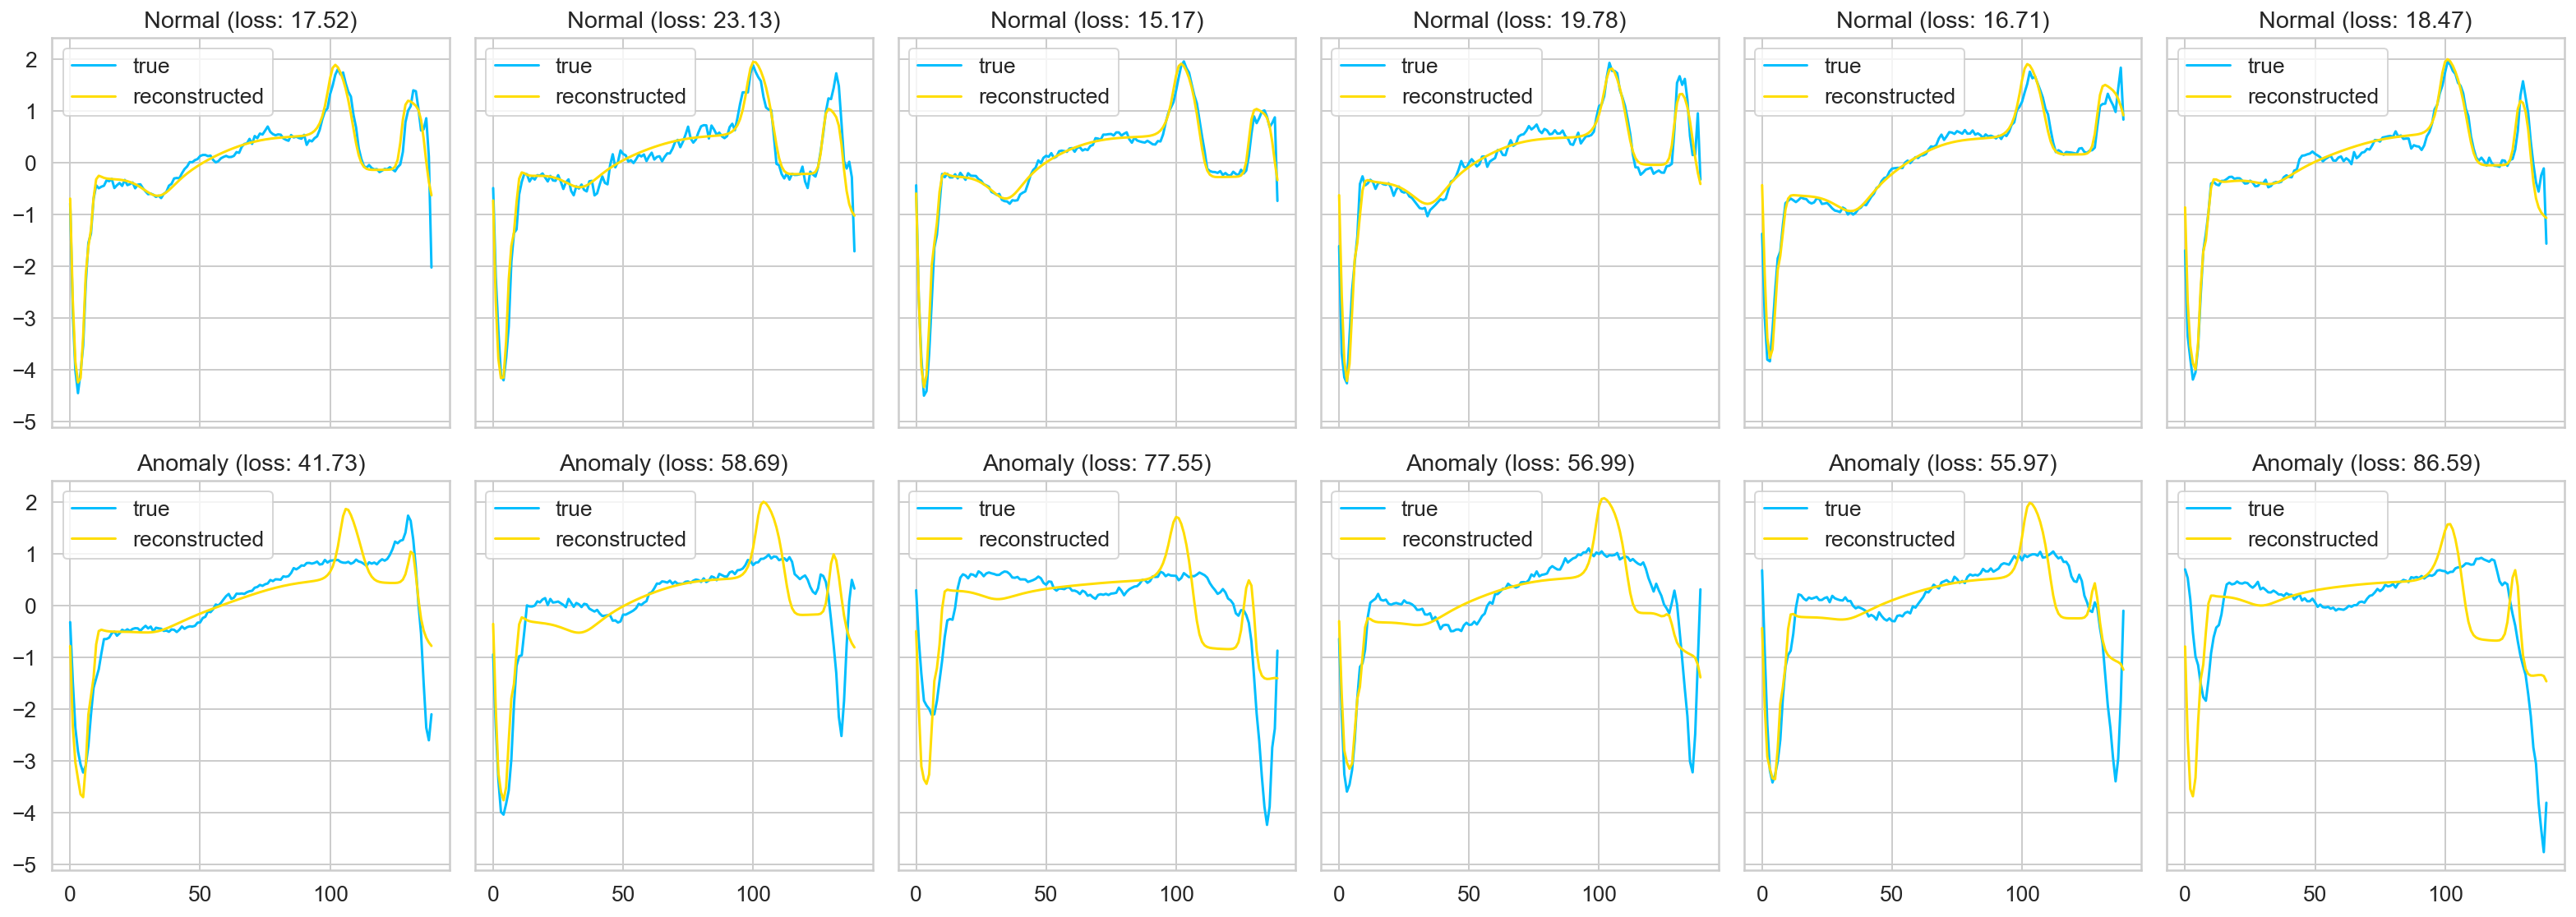

In [101]:
#### Looking at Examples

#We can overlay the real and reconstructed Time Series values to see how close they are. We'll do it for some normal and anomaly cases:

def plot_prediction(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])

    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()

fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
    plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
    plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

<br>
<br>
<br>

## Question 1

### 1.a

In [120]:
threhold_list = [15, 25, 35, 45, 55, 65, 75]

# predict normal cases
predictions, pred_losses = predict(model, test_normal_dataset)

# create lists to store correct counts
normal_correct = []
anomaly_correct = []


for THRESHOLD in threhold_list:
    correct = sum(l <= THRESHOLD for l in pred_losses)
    normal_correct.append(correct)
    print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')
    
print(normal_correct,'\n')



# predict anomaly cases
predictions, pred_losses = predict(model, anomaly_dataset)

for THRESHOLD in threhold_list:
    correct = sum(l > THRESHOLD for l in pred_losses)
    anomaly_correct.append(correct)
    print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')
    
print(anomaly_correct)

Correct normal predictions: 5/145
Correct normal predictions: 89/145
Correct normal predictions: 126/145
Correct normal predictions: 133/145
Correct normal predictions: 139/145
Correct normal predictions: 141/145
Correct normal predictions: 143/145
[5, 89, 126, 133, 139, 141, 143] 

Correct anomaly predictions: 145/145
Correct anomaly predictions: 144/145
Correct anomaly predictions: 144/145
Correct anomaly predictions: 142/145
Correct anomaly predictions: 137/145
Correct anomaly predictions: 106/145
Correct anomaly predictions: 51/145


[145, 144, 144, 142, 137, 106, 51]

In [121]:
# create table
anomaly_num = [145, 145, 145, 145, 145, 145, 145]
normal_num = [145, 145, 145, 145, 145, 145, 145]
table = pd.DataFrame()
table['Threshold'] = threhold_list
table['tp'] = anomaly_correct
table['fn'] = list(map(lambda x,y: x-y, anomaly_num,anomaly_correct))
table['tn'] = normal_correct
table['fp'] = list(map(lambda x,y: x-y, normal_num,normal_correct))
table['recall'] = table['tp']/(table['tp'] + table['fn'])
table['specificity'] = table['tn']/(table['tn'] + table['fp'])
table

,Threshold,tp,fn,tn,fp,recall,specificity
0,15,145,0,5,140,1.000000,0.034483
1,25,144,1,89,56,0.993103,0.613793
2,35,144,1,126,19,0.993103,0.868966
3,45,142,3,133,12,0.979310,0.917241
4,55,137,8,139,6,0.944828,0.958621
5,65,106,39,141,4,0.731034,0.972414
6,75,51,94,143,2,0.351724,0.986207


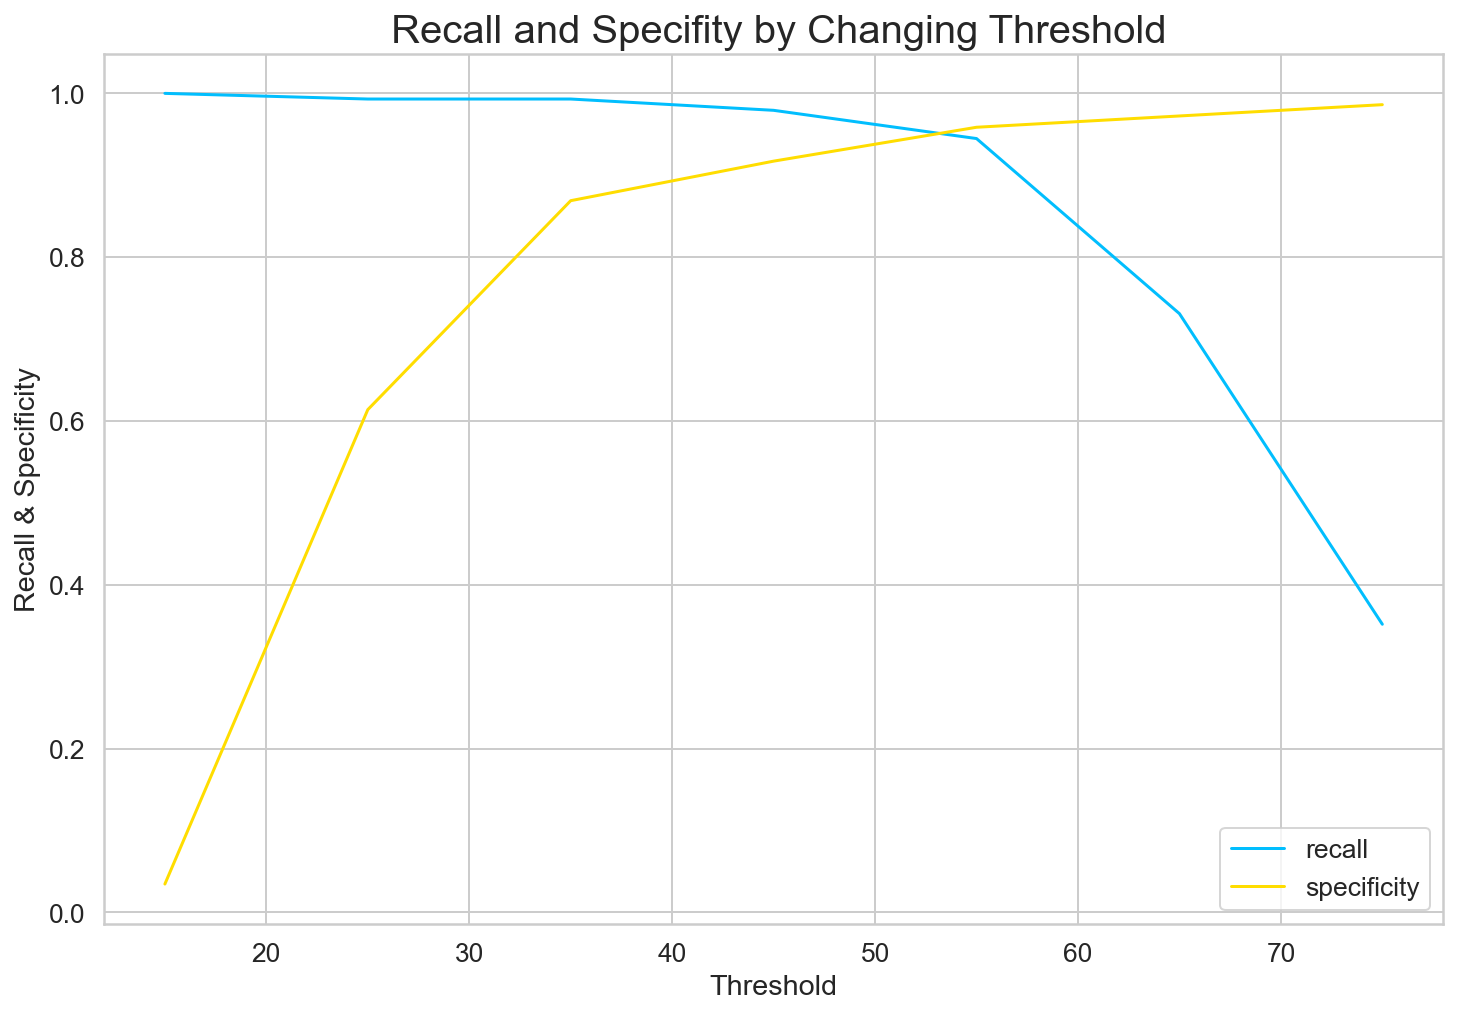

In [122]:
# plot
plt.plot(table['Threshold'], table['recall'])
plt.plot(table['Threshold'], table['specificity'])

plt.title(' Recall and Specifity by Changing Threshold',fontdict = {'fontsize' : 20})
plt.xlabel('Threshold')
plt.ylabel('Recall & Specificity')
plt.legend(['recall', 'specificity'], loc='best')
plt.show()

<br>
<br>

### 1.b

We created a table with both recall and specificity values. We chose to use abnormal heartbeats as positive and normal heartbeats as negative. As we can see from the table, the recall values are decreasing from 1 to 0.35 and the specificity values are increasing from 0.03 to 0.98. It makes sense because when the threshold is 15, the loss that is less than the threshold would be classified as normal (negative) and the rest would be classified as abnormal (positive) In this case, since we had a very low threshold, where all the heartbeats were classified as normal type would be all correct. So, the false negative rate is 0. Thus, the recall value should be 1. 

As we changed the threshold to some larger values, the false negative cases began to exist. So, the recall value decreases.

Through the graph, we can conclude that the best tradeoff point for the threshold is in the range of 45 to 55.

<br>
<br>
<br>

## Question 2

### 2.a

<br>

#### Embedding dimension = 2

In [123]:
model = RecurrentAutoencoder(seq_len, n_features, 2)
model = model.to(device)

In [124]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  #n_epochs=50
  n_epochs=25  
)

Epoch 1: train loss 85.3282823604905 val loss 70.33314402192933
Epoch 2: train loss 70.19643108271053 val loss 70.25039273154613
Epoch 3: train loss 69.42864252972247 val loss 69.38261224792272
Epoch 4: train loss 69.05986801418072 val loss 69.14635584704298
Epoch 5: train loss 68.87317812303438 val loss 68.87984654032736
Epoch 6: train loss 68.71948980525923 val loss 68.9697010443886
Epoch 7: train loss 68.53679773222291 val loss 68.71134653189077
Epoch 8: train loss 68.3571661995669 val loss 68.466719096838
Epoch 9: train loss 68.09581781346584 val loss 68.17016434913609
Epoch 10: train loss 67.70178469896605 val loss 68.81948960600452
Epoch 11: train loss 67.62520932247926 val loss 67.79617157242811
Epoch 12: train loss 67.4480588683098 val loss 67.7202083600666
Epoch 13: train loss 67.33843751051694 val loss 67.63013704319457
Epoch 14: train loss 67.26795552171848 val loss 67.6826321338224
Epoch 15: train loss 67.16626296837164 val loss 67.91748981671121
Epoch 16: train loss 67.042

In [126]:
train_loss_2 = 65.4692
validation_loss_2 = 65.1457

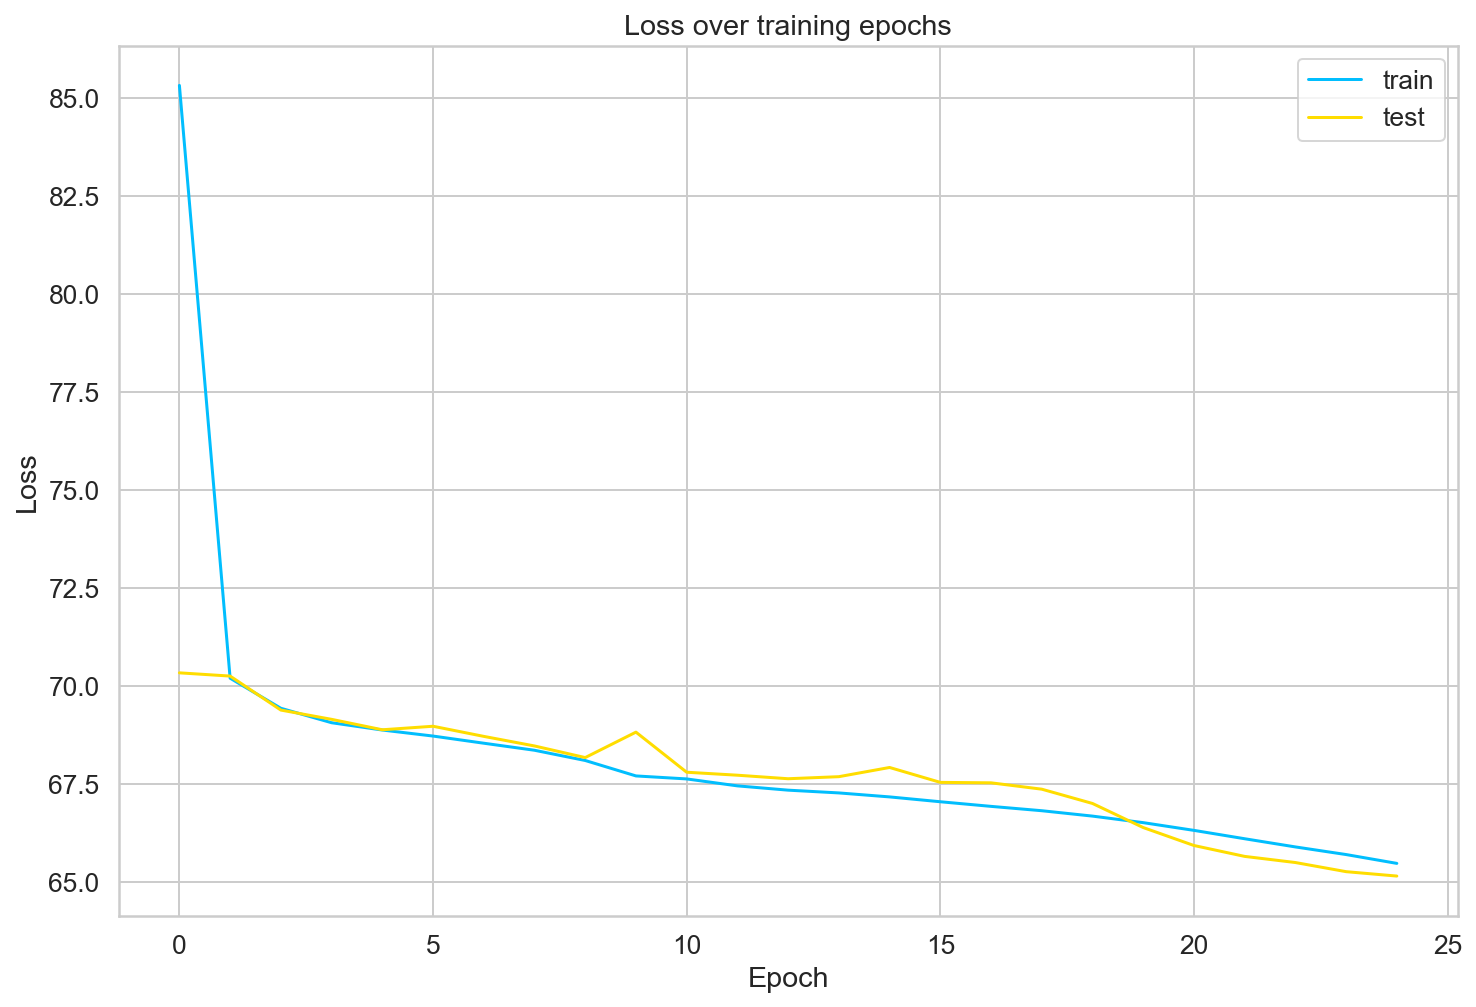

In [125]:
# plot

ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [134]:
## calculate proportion of normal and abnormal correctly classified

# set threshold to 45
THRESHOLD = 45

# predict normal cases
predictions, pred_losses = predict(model, test_normal_dataset)

normal_correct_2 = sum(l <= THRESHOLD for l in pred_losses)
#normal_correct_2.append(correct)
print(f'Correct normal predictions: {normal_correct_2}/{len(test_normal_dataset)}')
    
#print(normal_correct_2,'\n')



# predict anomaly cases
predictions, pred_losses = predict(model, anomaly_dataset)

anomaly_correct_2 = sum(l > THRESHOLD for l in pred_losses)
#anomaly_correct_2.append(correct)
print(f'Correct anomaly predictions: {anomaly_correct_2}/{len(anomaly_dataset)}')
    
#print(anomaly_correct_2)

Correct normal predictions: 2/145
Correct anomaly predictions: 144/145


In [137]:
table = pd.DataFrame()
table['Threshold'] = [45]
table['tp'] = [anomaly_correct_2]
table['fn'] = [145 - anomaly_correct_2]
table['tn'] = [normal_correct_2]
table['fp'] = [145 - normal_correct_2]
table['recall'] = table['tp']/(table['tp'] + table['fn'])
table['specificity'] = table['tn']/(table['tn'] + table['fp'])
table

,Threshold,tp,fn,tn,fp,recall,specificity
0,45,144,1,2,143,0.993103,0.013793


<br>

#### Embedding dimension = 4

In [138]:
model = RecurrentAutoencoder(seq_len, n_features, 4)
model = model.to(device)

In [139]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  #n_epochs=50
  n_epochs=25  
)

Epoch 1: train loss 75.12240508793343 val loss 68.46473524594876
Epoch 2: train loss 69.11158725995298 val loss 67.93287089741678
Epoch 3: train loss 68.36847192901894 val loss 68.2052998982192
Epoch 4: train loss 67.85517765830862 val loss 67.44172919732311
Epoch 5: train loss 67.22803599408729 val loss 66.32153630175281
Epoch 6: train loss 62.87313745291855 val loss 58.94565054987885
Epoch 7: train loss 56.36835987901361 val loss 55.0248696128663
Epoch 8: train loss 54.75072966194691 val loss 53.57505381717617
Epoch 9: train loss 53.26312892872304 val loss 52.265429395864444
Epoch 10: train loss 52.56318350580132 val loss 51.73664090413689
Epoch 11: train loss 52.11446461260487 val loss 51.402028939829755
Epoch 12: train loss 51.63502866075386 val loss 50.870450211873234
Epoch 13: train loss 51.00410513779849 val loss 50.08557592398478
Epoch 14: train loss 50.77541433116785 val loss 50.42379687182326
Epoch 15: train loss 50.62628813916183 val loss 49.72254802586682
Epoch 16: train lo

In [143]:
train_loss_4 = 43.9417
validation_loss_4 = 48.3208

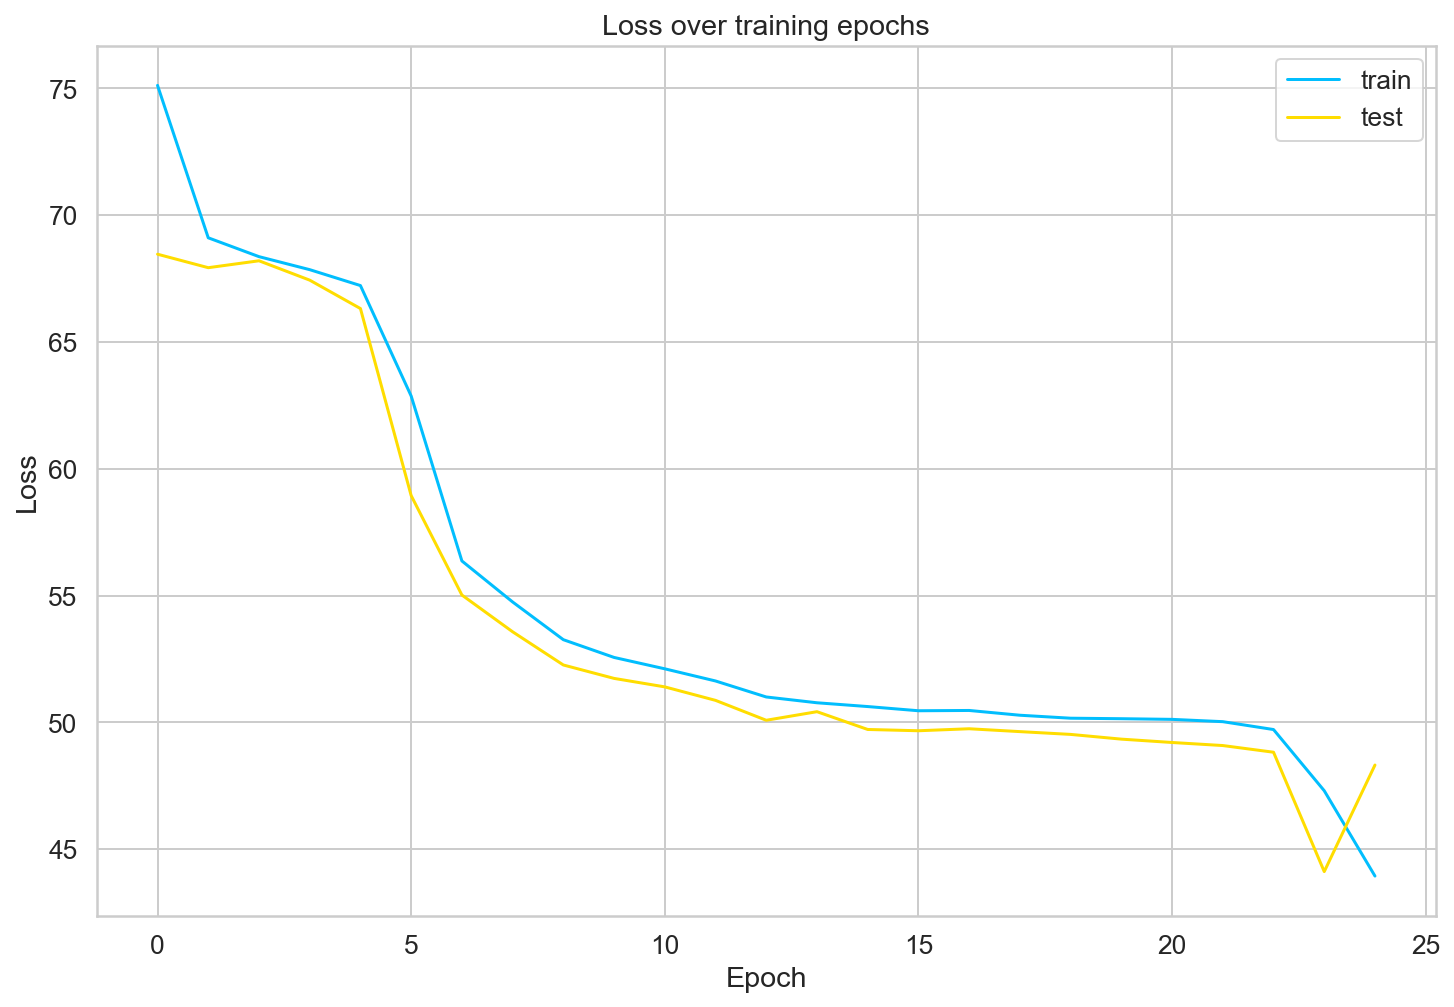

In [140]:
# plot

ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [141]:
## calculate proportion of normal and abnormal correctly classified

# predict normal cases
predictions, pred_losses = predict(model, test_normal_dataset)

normal_correct_4 = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {normal_correct_4}/{len(test_normal_dataset)}')


# predict anomaly cases
predictions, pred_losses = predict(model, anomaly_dataset)

anomaly_correct_4 = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {anomaly_correct_4}/{len(anomaly_dataset)}')

Correct normal predictions: 96/145
Correct anomaly predictions: 144/145


In [142]:
table = pd.DataFrame()
table['Threshold'] = [45]
table['tp'] = [anomaly_correct_4]
table['fn'] = [145 - anomaly_correct_4]
table['tn'] = [normal_correct_4]
table['fp'] = [145 - normal_correct_4]
table['recall'] = table['tp']/(table['tp'] + table['fn'])
table['specificity'] = table['tn']/(table['tn'] + table['fp'])
table

,Threshold,tp,fn,tn,fp,recall,specificity
0,45,144,1,96,49,0.993103,0.662069


<br>

#### Embedding dimension = 6

In [146]:
model = RecurrentAutoencoder(seq_len, n_features, 6)
model = model.to(device)

In [147]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  #n_epochs=50
  n_epochs=25  
)

Epoch 1: train loss 80.10159634332992 val loss 69.45943492589957
Epoch 2: train loss 68.5847869897648 val loss 69.58674941860369
Epoch 3: train loss 67.44946623636513 val loss 66.59638663282166
Epoch 4: train loss 60.79473504708785 val loss 56.06210690390942
Epoch 5: train loss 54.61211047235971 val loss 53.02268385643031
Epoch 6: train loss 52.498649035956966 val loss 52.16265047613671
Epoch 7: train loss 51.67034139867657 val loss 50.811008635641365
Epoch 8: train loss 50.869884227274504 val loss 50.406308014645106
Epoch 9: train loss 50.16126121142755 val loss 48.609046311101814
Epoch 10: train loss 47.771776519922994 val loss 45.184227360800264
Epoch 11: train loss 43.654484120360884 val loss 41.83264550739588
Epoch 12: train loss 41.285141171874756 val loss 41.27633984666635
Epoch 13: train loss 39.16610556713567 val loss 38.27130778576327
Epoch 14: train loss 36.753657336006334 val loss 39.80681984416454
Epoch 15: train loss 35.12342676449475 val loss 39.54978761249842
Epoch 16: 

In [151]:
train_loss_6 = 30.2485
validation_loss_6 = 30.5892

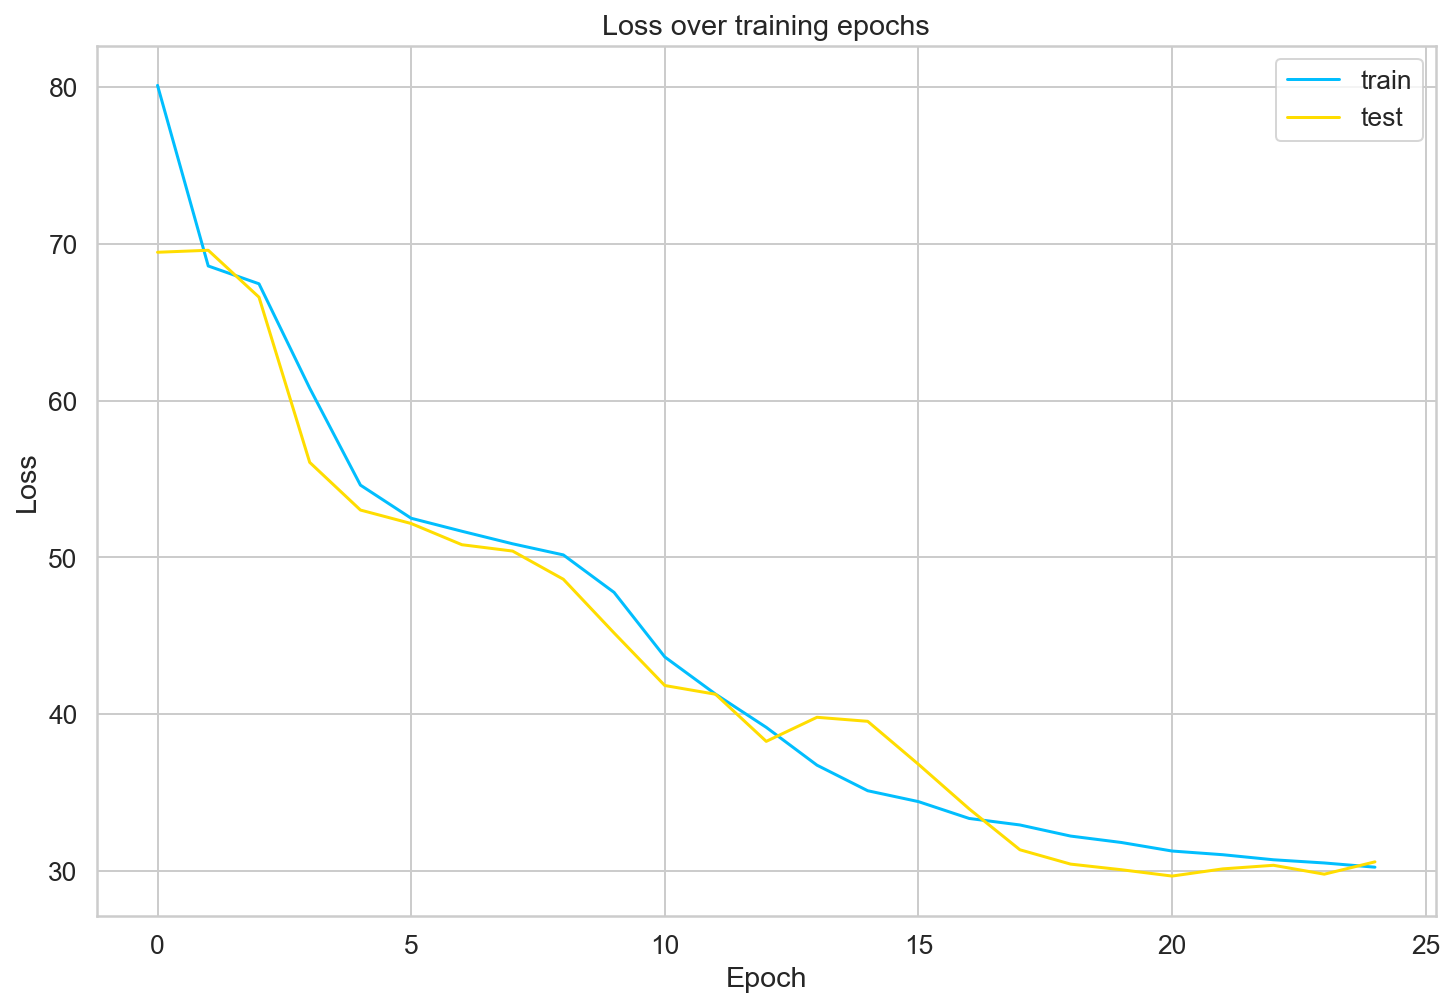

In [152]:
# plot

ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [153]:
## calculate proportion of normal and abnormal correctly classified

# predict normal cases
predictions, pred_losses = predict(model, test_normal_dataset)

normal_correct_6 = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {normal_correct_6}/{len(test_normal_dataset)}')


# predict anomaly cases
predictions, pred_losses = predict(model, anomaly_dataset)

anomaly_correct_6 = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {anomaly_correct_6}/{len(anomaly_dataset)}')

Correct normal predictions: 134/145
Correct anomaly predictions: 144/145


In [154]:
table = pd.DataFrame()
table['Threshold'] = [45]
table['tp'] = [anomaly_correct_6]
table['fn'] = [145 - anomaly_correct_6]
table['tn'] = [normal_correct_6]
table['fp'] = [145 - normal_correct_6]
table['recall'] = table['tp']/(table['tp'] + table['fn'])
table['specificity'] = table['tn']/(table['tn'] + table['fp'])
table

,Threshold,tp,fn,tn,fp,recall,specificity
0,45,144,1,134,11,0.993103,0.924138


<br>

#### Embedding dimension = 8

In [155]:
model = RecurrentAutoencoder(seq_len, n_features, 8)
model = model.to(device)

In [156]:
model, history = train_model(
  model, 
  train_dataset, 
  val_dataset, 
  #n_epochs=50
  n_epochs=25  
)

Epoch 1: train loss 74.94317404621313 val loss 68.84688836315793
Epoch 2: train loss 68.87462941161667 val loss 69.91624177275257
Epoch 3: train loss 68.01117696612172 val loss 67.26316218978309
Epoch 4: train loss 64.20154242955692 val loss 58.07572128504209
Epoch 5: train loss 55.67252972259583 val loss 52.67479570408323
Epoch 6: train loss 52.02491848971372 val loss 51.52778788231338
Epoch 7: train loss 50.61542492074286 val loss 49.52904748102911
Epoch 8: train loss 50.6856421102011 val loss 50.180626709713465
Epoch 9: train loss 49.68157209037341 val loss 49.221263735774436
Epoch 10: train loss 49.172893697145916 val loss 48.873582996199154
Epoch 11: train loss 48.77751186959737 val loss 48.17548412674523
Epoch 12: train loss 48.38147914645077 val loss 47.97589046881874
Epoch 13: train loss 48.14723659839807 val loss 47.52952782692763
Epoch 14: train loss 47.90983063998793 val loss 47.218461371932825
Epoch 15: train loss 47.665943500160544 val loss 47.081753753557955
Epoch 16: tra

In [157]:
train_loss_8 = 39.5346
validation_loss_8 = 39.1086

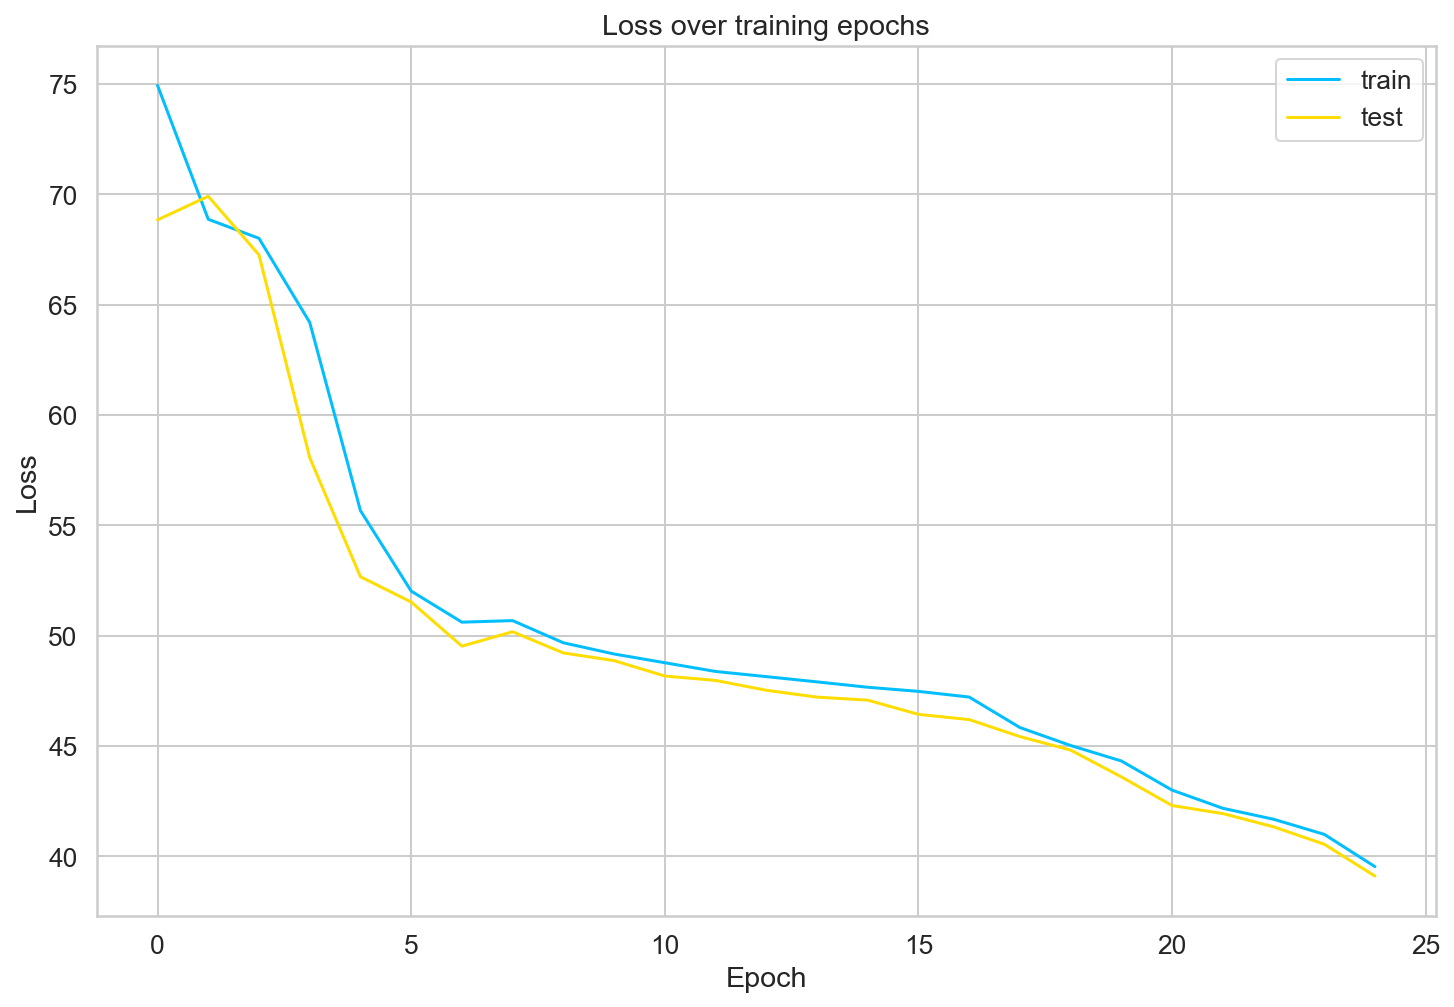

In [158]:
# plot

ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [159]:
## calculate proportion of normal and abnormal correctly classified

# predict normal cases
predictions, pred_losses = predict(model, test_normal_dataset)

normal_correct_8 = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {normal_correct_8}/{len(test_normal_dataset)}')


# predict anomaly cases
predictions, pred_losses = predict(model, anomaly_dataset)

anomaly_correct_8 = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {anomaly_correct_8}/{len(anomaly_dataset)}')

Correct normal predictions: 116/145
Correct anomaly predictions: 143/145


In [160]:
table = pd.DataFrame()
table['Threshold'] = [45]
table['tp'] = [anomaly_correct_8]
table['fn'] = [145 - anomaly_correct_8]
table['tn'] = [normal_correct_8]
table['fp'] = [145 - normal_correct_8]
table['recall'] = table['tp']/(table['tp'] + table['fn'])
table['specificity'] = table['tn']/(table['tn'] + table['fp'])
table

,Threshold,tp,fn,tn,fp,recall,specificity
0,45,143,2,116,29,0.986207,0.8


<br>

In [161]:
# report loss table

losstable = pd.DataFrame()
losstable['Embedding Dimension'] = [2,4,6,8]
losstable['Training Loss'] = [train_loss_2, train_loss_4, train_loss_6, train_loss_8]
losstable['Validation Loss'] = [validation_loss_2, validation_loss_4, validation_loss_6, validation_loss_8]
losstable

,Embedding Dimension,Training Loss,Validation Loss
0,2,65.4692,65.1457
1,4,43.9417,48.3208
2,6,30.2485,30.5892
3,8,39.5346,39.1086


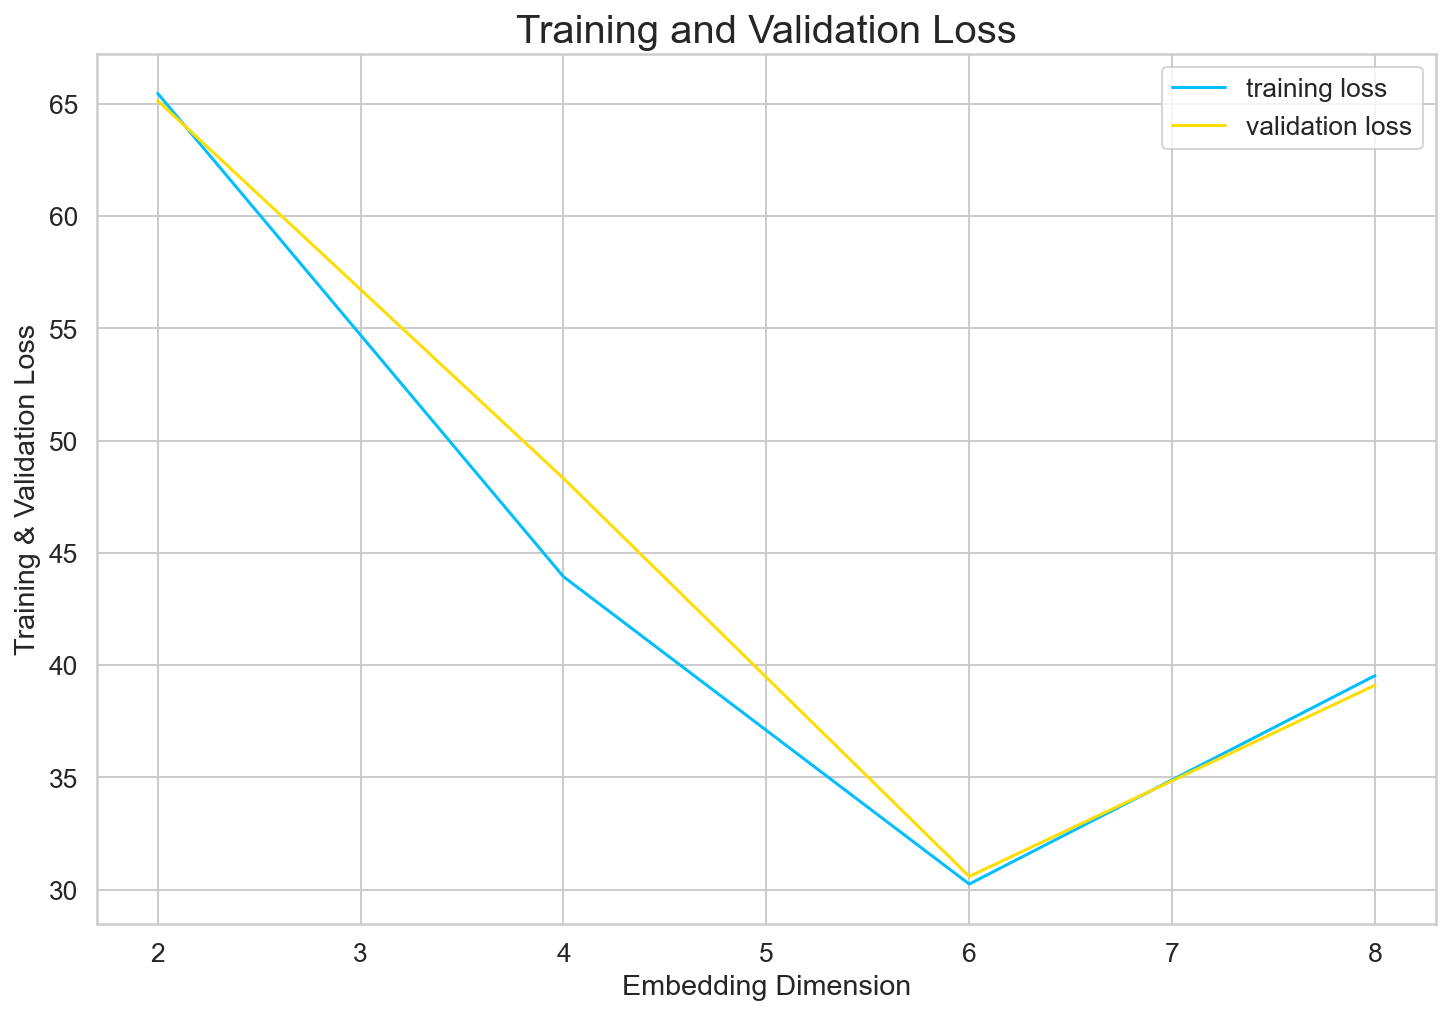

In [163]:
# plot

plt.plot(losstable['Embedding Dimension'], losstable['Training Loss'])
plt.plot(losstable['Embedding Dimension'], losstable['Validation Loss'])

plt.title('Training and Validation Loss',fontdict = {'fontsize' : 20})
plt.xlabel('Embedding Dimension')
plt.ylabel('Training & Validation Loss')
plt.legend(['training loss', 'validation loss'], loc='best')

plt.show()


<br>
<br>

### 2.b

From both the table and graph above, we can see that the training and validation losses are decreasing as the embedding dimension increases until 6. After we changed the dimension to 8, both losses went up. The best training loss is about 30.2485 and the best validation loss is about 30.5892. We think that the result met our expectations since there are 5 different types of heartbeats in this dataset, so using the dimension of 6 would give the best result.

<br>
<br>

### 2.c

In [165]:
accuracytable = pd.DataFrame()
accuracytable['Embedding Dimension'] = [2,4,6,8]
accuracytable['tp'] = [anomaly_correct_2, anomaly_correct_4, anomaly_correct_6, anomaly_correct_8]
accuracytable['fn'] = [145 - anomaly_correct_2, 145 - anomaly_correct_4, 145 - anomaly_correct_6, 145 - anomaly_correct_8]
accuracytable['tn'] = [normal_correct_2, normal_correct_4, normal_correct_6, normal_correct_8]
accuracytable['fp'] = [145 - normal_correct_2, 145 - normal_correct_4, 145 - normal_correct_6, 145 - normal_correct_8]
accuracytable['recall'] = accuracytable['tp']/(accuracytable['tp'] + accuracytable['fn'])
accuracytable['specificity'] = accuracytable['tn']/(accuracytable['tn'] + accuracytable['fp'])

accuracytable

,Embedding Dimension,tp,fn,tn,fp,recall,specificity
0,2,144,1,2,143,0.993103,0.013793
1,4,144,1,96,49,0.993103,0.662069
2,6,144,1,134,11,0.993103,0.924138
3,8,143,2,116,29,0.986207,0.800000


<br>
<br>

### 2.d

As we can see from the table above, the recall value stays pretty much the same for 4 different dimensions. We think it's because we used the same threshold (45) to train the model. From question 1, we concluded that any number from the range 45-55 would be a good choice for the threshold. Therefore, we expect to see some high recall (true positive) values. 